In [1]:
import sys
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_absolute_error
from IPython.display import clear_output
import matplotlib.pyplot as plt

from sklearn.utils.deprecation import _raise_dep_warning_if_not_pytest
from lazypredict.Supervised import LazyRegressor
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import Counter

csv_path='/Users/lorneluo/lorne/poolhub/dataset/debug/annotation/colors.csv'
image_folder='/Users/lorneluo/lorne/poolhub/dataset/debug/annotation'

/Users/lorneluo/lorne/poolhub/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Quick training


In [15]:
def hsv_scatter_chart(chemistry, df, elevation=None, azimuth=None):
    df = df.sort_values(f'{chemistry}_value')

    fig = plt.figure(figsize=(30, 18))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('$RED$', fontsize=15)
    ax.set_ylabel('$GREEN$', fontsize=15, rotation=150)
    ax.set_zlabel('$BLUE$', fontsize=15, rotation=50)

    plt.title(label=chemistry, fontsize=40, color="gray")
    # sequence line
    ax.plot3D(df[f'{chemistry}_color_h'],
              df[f'{chemistry}_color_s'],
              df[f'{chemistry}_color_v'], 'gray')

    # colors_hex = ['#%02x%02x%02x' % (df.at[i, f'{chemistry}_color_h'],
    #                                  df.at[i, f'{chemistry}_color_s'],
    #                                  df.at[i, f'{chemistry}_color_v']) for i in df.index]
    # ax.scatter(df[f'{chemistry}_color_r'],
    #            df[f'{chemistry}_color_g'],
    #            df[f'{chemistry}_color_b'],
    #            c=colors_hex, s=200, marker='D')

    for i in df.index:
        ax.text(df.at[i, f'{chemistry}_color_h'],
                df.at[i, f'{chemistry}_color_s'],
                df.at[i, f'{chemistry}_color_v'],
                f"{df.at[i, f'{chemistry}_value']}", size=8, zorder=10, color='k',
                # f"{df.at[i, 'actual_value']}_{df.at[i, 'file_path']}", size=8, zorder=10, color='k'
                )

    ax.view_init(elevation, azimuth)
    plt.savefig(f'{chemistry}_scatter.png')
    plt.show()

In [16]:
hsv_csv_path='/Users/lorneluo/lorne/poolhub/dataset/debug/annotation/hsv_value.csv'
df = pd.read_csv(hsv_csv_path)
df = df.sort_values(f'th_value')
df.head()


,filename,th_color_h,th_color_s,th_color_v,th_value,tc_color_h,tc_color_s,tc_color_v,tc_value,fc_color_h,...,ph_color_v,ph_value,ta_color_h,ta_color_s,ta_color_v,ta_value,ca_color_h,ca_color_s,ca_color_v,ca_value
42,IMG_7490.jpg,0.62,0.55,0.45,17,0.12,0.36,0.86,nan,0.15,...,0.72,7.50,0.13,0.60,0.59,33,0.07,0.64,0.58,17.00
29,IMG_7282.jpg,0.64,0.49,0.38,43,0.13,0.39,0.85,0.14,0.14,...,0.67,7.20,0.22,0.53,0.33,85,0.03,0.62,0.47,80.00
28,IMG_7281.jpg,0.64,0.41,0.45,43,0.15,0.30,0.77,0.14,0.16,...,0.69,7.20,0.22,0.37,0.40,85,0.03,0.46,0.55,80.00
19,File_021.jpeg,0.64,0.49,0.48,55,0.12,0.34,0.84,0.44,0.14,...,0.69,7.80,0.23,0.45,0.43,135,0.07,0.68,0.56,5.00
24,File_026.jpeg,0.62,0.79,0.37,70,0.12,0.38,0.78,0.13,0.12,...,0.64,7.50,0.13,0.60,0.54,64,0.08,0.64,0.49,5.00


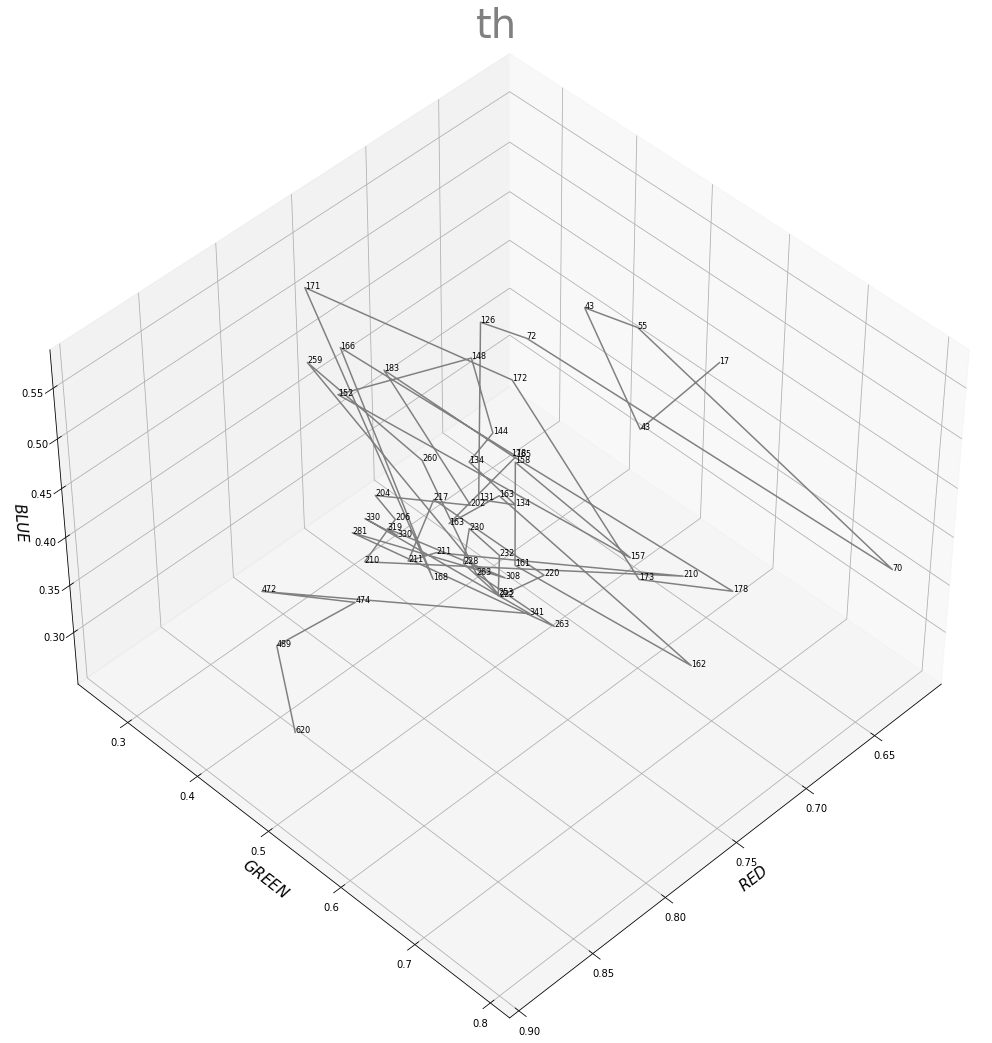

In [4]:
hsv_scatter_chart('th', df, 45,45)


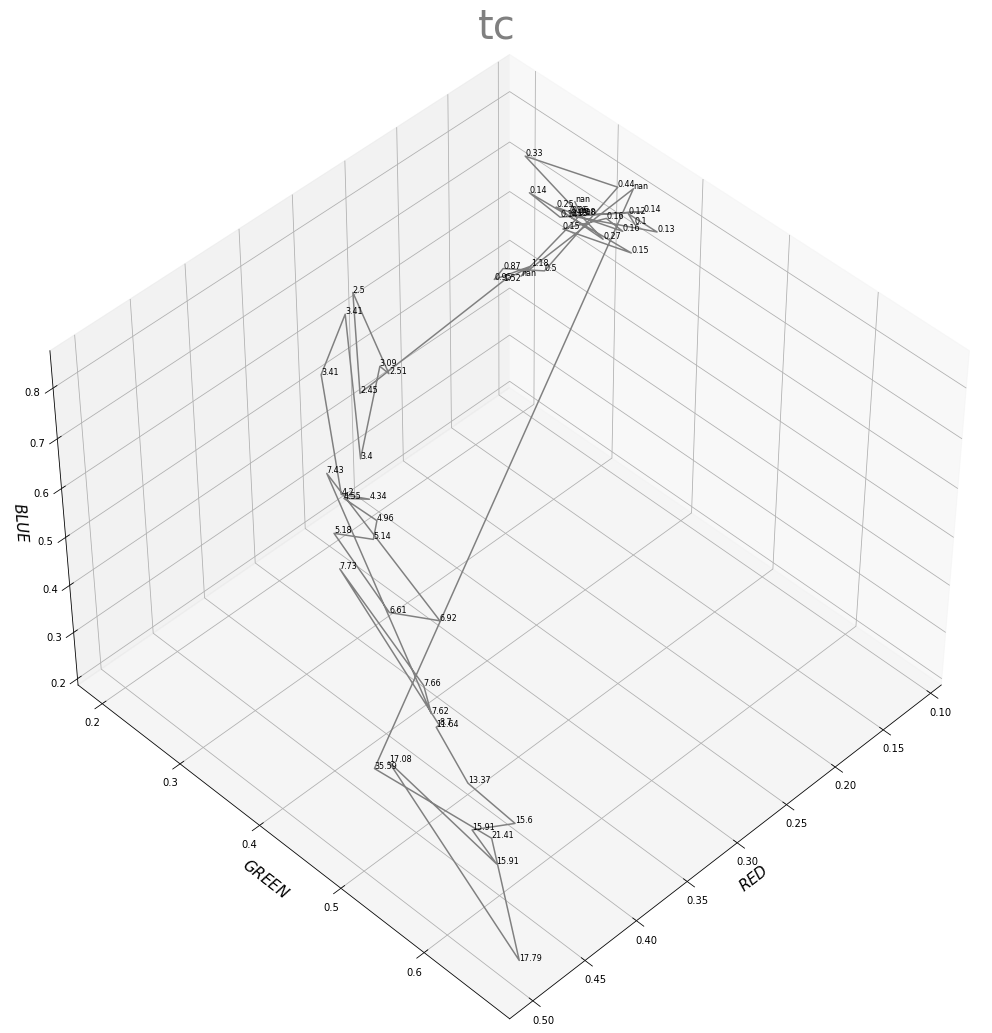

<Axes3DSubplot:title={'center':'tc'}, xlabel='$RED$', ylabel='$GREEN$'>

In [21]:
hsv_scatter_chart('tc', df, 45,45)


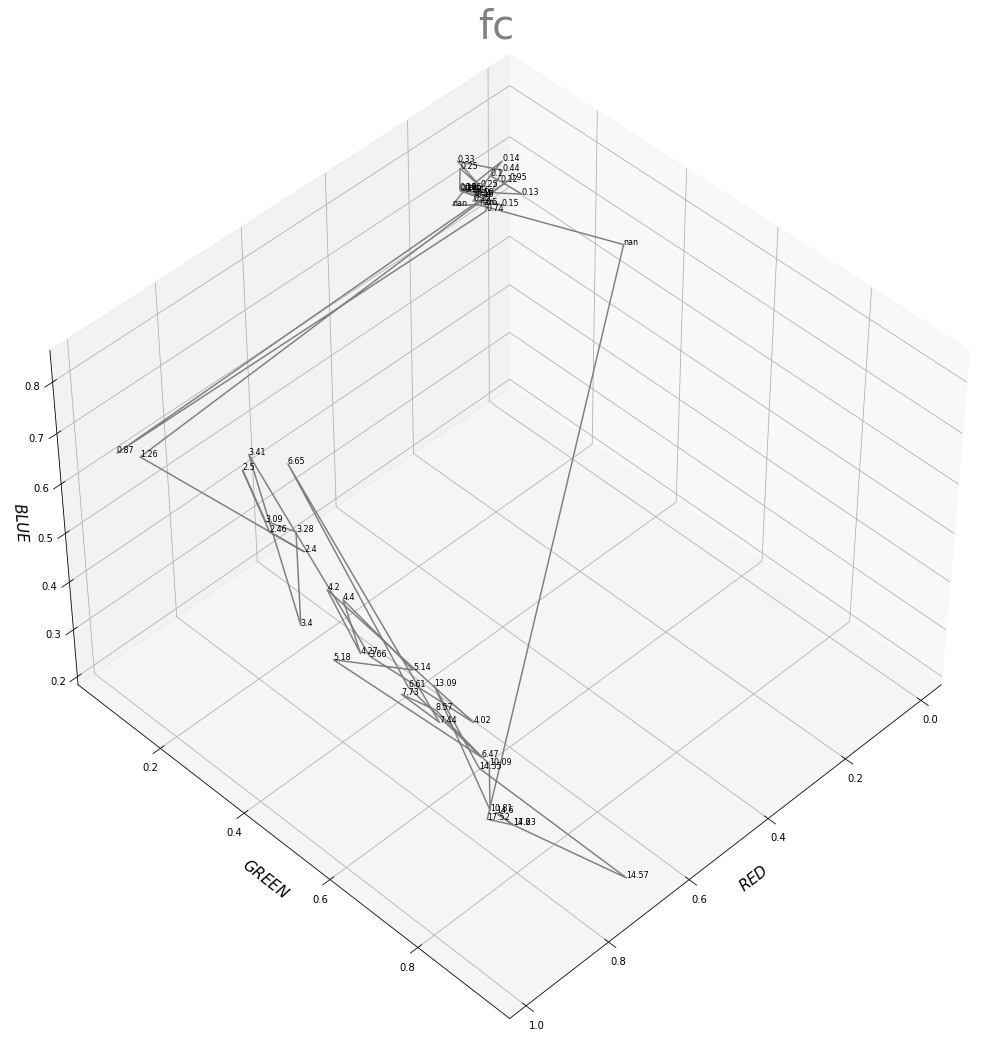

<Axes3DSubplot:title={'center':'fc'}, xlabel='$RED$', ylabel='$GREEN$'>

In [33]:
hsv_scatter_chart('fc', df, 45,45)

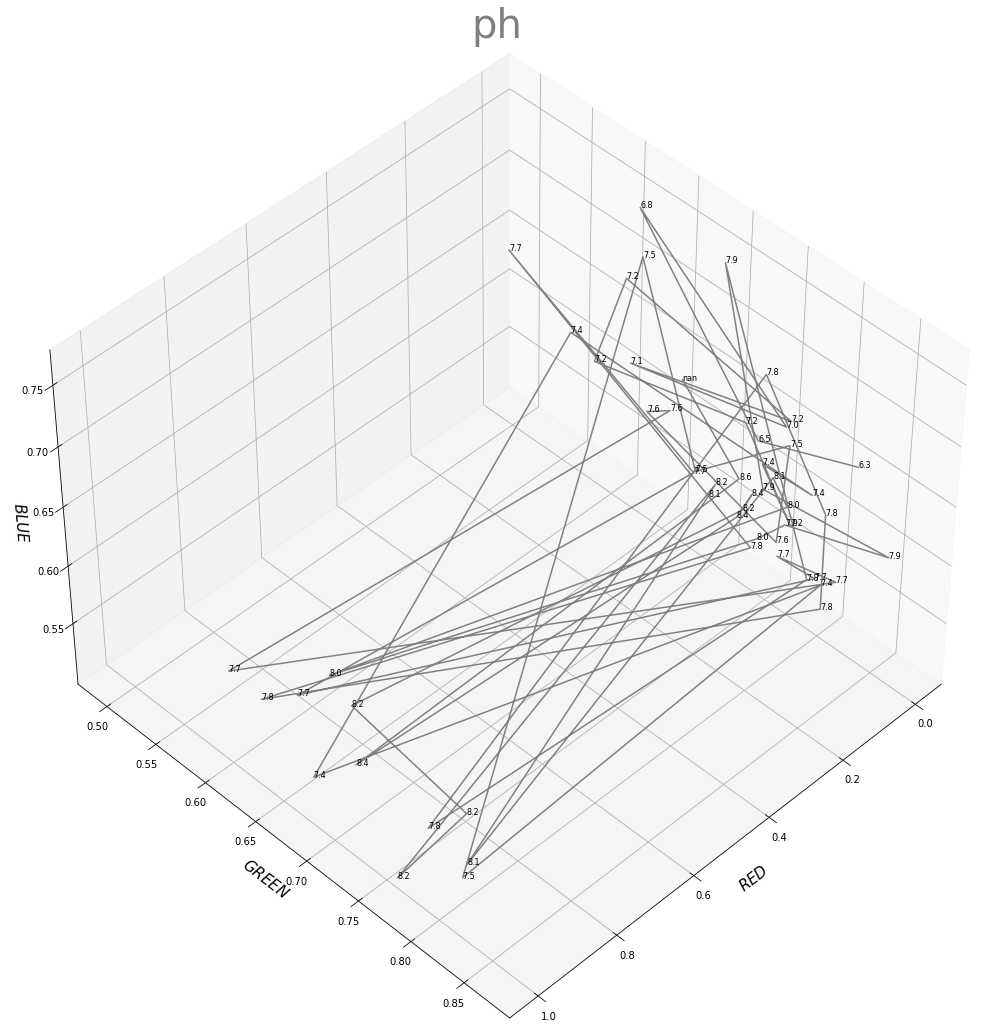

<Axes3DSubplot:title={'center':'ph'}, xlabel='$RED$', ylabel='$GREEN$'>

In [37]:
hsv_scatter_chart('ph', df, 45,45)

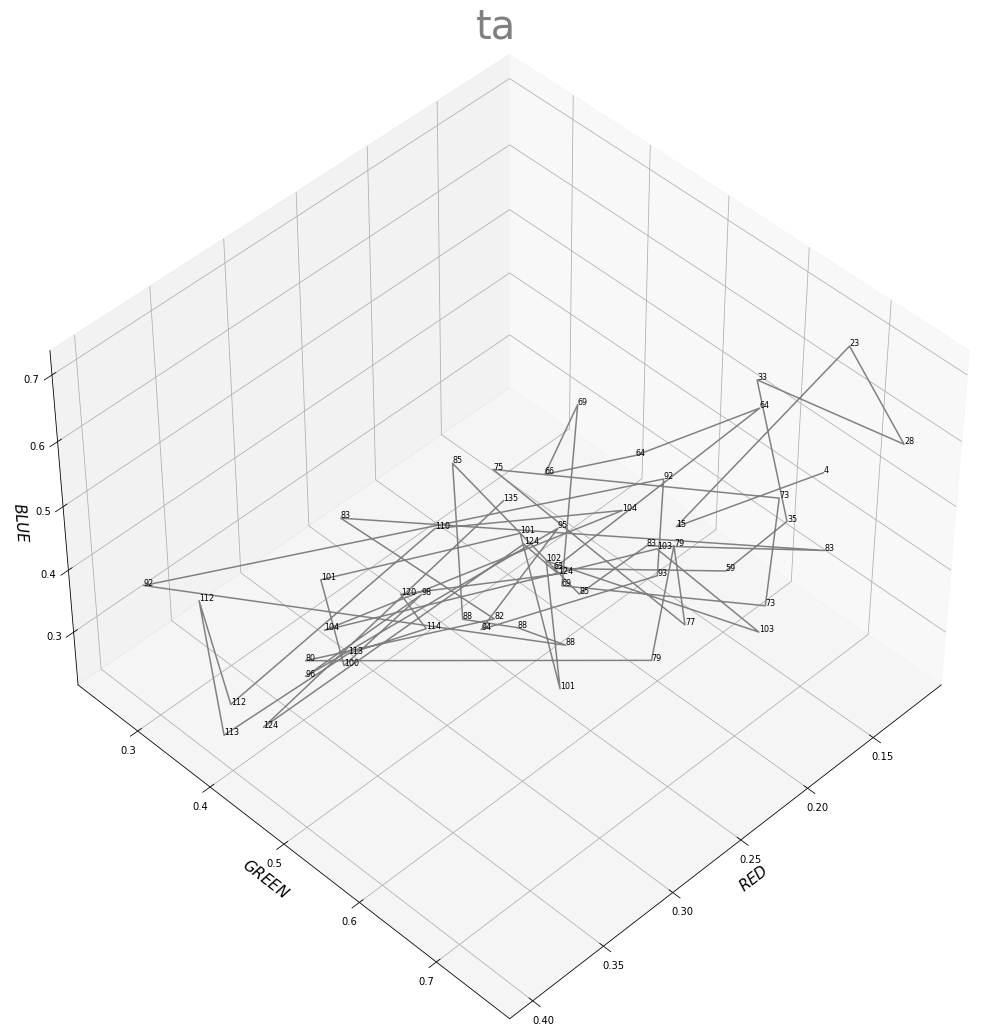

<Axes3DSubplot:title={'center':'ta'}, xlabel='$RED$', ylabel='$GREEN$'>

In [35]:
hsv_scatter_chart('ta', df, 45,45)

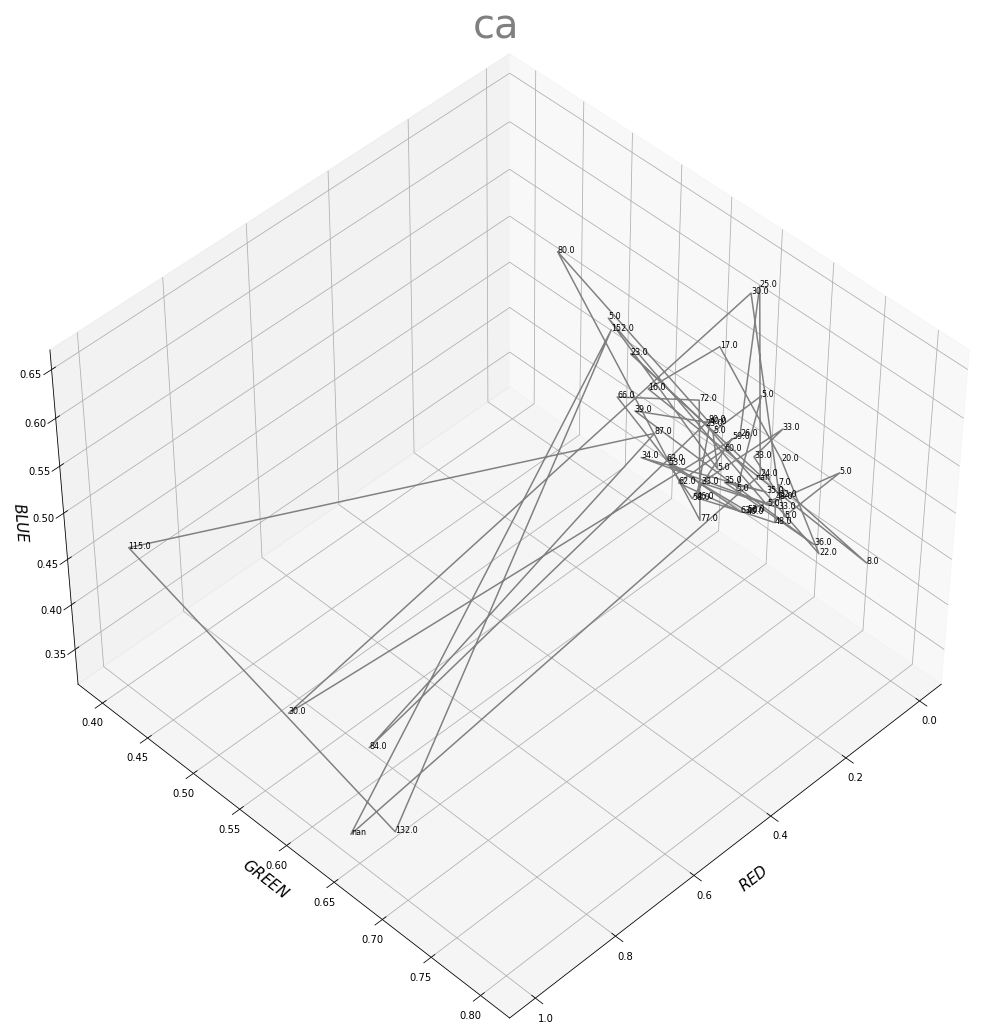

<Axes3DSubplot:title={'center':'ca'}, xlabel='$RED$', ylabel='$GREEN$'>

In [36]:
hsv_scatter_chart('ca', df, 45,45)

In [30]:
def fit_and_evaluate(csv_filename,value_index,color_index):
    converter = {value_index: lambda s: np.float(s.strip() or 'Nan')}
    dataset=np.loadtxt(csv_filename, delimiter=',', skiprows=1,
                       usecols = (*color_index,value_index),converters=converter)
    # exclude row where value is empty
    dataset=dataset[~np.isnan(dataset).any(axis=1), :]

    X=dataset[:,0:3]
    y=dataset[:,3]
    # X=np.loadtxt(csv_filename, delimiter=',', skiprows=1,usecols = (*color_index,))
    # y=np.loadtxt(csv_filename, delimiter=',', skiprows=1,usecols = (value_index,))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    reg = LazyRegressor(predictions=True,custom_metric=mean_absolute_error)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    return models

def evaluate_models(csv_path,value_index,color_index,count=100):
    best_models=[]
    best_rmse=[]

    for i in range(count):
        models=fit_and_evaluate(csv_path,value_index,color_index)
        for j in range(len(models['RMSE'])):
            if models['RMSE'].iloc[j] == models['RMSE'].iloc[0]:
                best_model,rmse=models['RMSE'].index[0],models['RMSE'].iloc[0]
                best_models.append(best_model)
                best_rmse.append(rmse)

    clear_output()
    return Counter(best_models),best_rmse

## Single Training


In [8]:
# TH
models = fit_and_evaluate('th.csv',4,(1,2,3))
print(models)
print(models['RMSE'].nsmallest(1).values)
print(models['RMSE'].iloc[0])


100%|██████████| 42/42 [00:01<00:00, 27.99it/s]


                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
PassiveAggressiveRegressor                   0.97       0.98   15.77   
Ridge                                        0.97       0.98   16.36   
RidgeCV                                      0.97       0.98   16.65   
SGDRegressor                                 0.96       0.97   16.88   
LassoCV                                      0.96       0.97   16.90   
Lasso                                        0.96       0.97   17.24   
HuberRegressor                               0.96       0.97   17.65   
BayesianRidge                                0.95       0.97   19.30   
ElasticNetCV                                 0.95       0.96   20.41   
LassoLars                                    0.94       0.96   21.92   
AdaBoostRegressor                            0.93       0.95   22.98   
LassoLarsCV                                  0.92       0.94   2

## Evaluate all chemistry

In [20]:
# TH
value_index=4
color_index=(1,2,3)
models,best_rmse=evaluate_models(hsv_csv_path,value_index,color_index,100)
print(models)
print(f'Min RMSE = {min(best_rmse)}')
print(f'Avg RMSE = {sum(best_rmse) / len(best_rmse)}')
print(f'Max RMSE = {max(best_rmse)}')

Counter({'PoissonRegressor': 17, 'ExtraTreesRegressor': 15, 'RandomForestRegressor': 13, 'AdaBoostRegressor': 8, 'BaggingRegressor': 8, 'XGBRegressor': 7, 'DecisionTreeRegressor': 7, 'Ridge': 3, 'LassoLars': 3, 'PassiveAggressiveRegressor': 3, 'RANSACRegressor': 2, 'OrthogonalMatchingPursuitCV': 2, 'ElasticNetCV': 2, 'KNeighborsRegressor': 2, 'LinearRegression': 2, 'GammaRegressor': 1, 'Lasso': 1, 'BayesianRidge': 1, 'ElasticNet': 1, 'RidgeCV': 1, 'GradientBoostingRegressor': 1, 'OrthogonalMatchingPursuit': 1})
Min RMSE = 17.270507375291555
Avg RMSE = 38.82992224904512
Max RMSE = 62.71115817389158


In [28]:
# TC
value_index=8
color_index=(5,6,7)
models,best_rmse=evaluate_models(hsv_csv_path,value_index,color_index,100)
print(models)
print(f'Min RMSE = {min(best_rmse)}')
print(f'Avg RMSE = {sum(best_rmse) / len(best_rmse)}')
print(f'Max RMSE = {max(best_rmse)}')

Counter({'OrthogonalMatchingPursuit': 14, 'KNeighborsRegressor': 12, 'MLPRegressor': 12, 'ExtraTreesRegressor': 10, 'XGBRegressor': 8, 'DecisionTreeRegressor': 6, 'PoissonRegressor': 6, 'ExtraTreeRegressor': 5, 'BaggingRegressor': 5, 'RandomForestRegressor': 5, 'GradientBoostingRegressor': 4, 'AdaBoostRegressor': 3, 'SVR': 3, 'RANSACRegressor': 2, 'HuberRegressor': 2, 'TweedieRegressor': 2, 'GaussianProcessRegressor': 1, 'PassiveAggressiveRegressor': 1})
Min RMSE = 0.24689986928823096
Avg RMSE = 2.0951317368283338
Max RMSE = 6.9833264136758295


In [29]:
# FC
value_index=12
color_index=(9,10,11)
models,best_rmse=evaluate_models(hsv_csv_path,value_index,color_index,100)
print(models)
print(f'Min RMSE = {min(best_rmse)}')
print(f'Avg RMSE = {sum(best_rmse) / len(best_rmse)}')
print(f'Max RMSE = {max(best_rmse)}')

Counter({'ExtraTreesRegressor': 17, 'KNeighborsRegressor': 16, 'GradientBoostingRegressor': 10, 'PoissonRegressor': 7, 'ExtraTreeRegressor': 7, 'AdaBoostRegressor': 6, 'GammaRegressor': 6, 'RandomForestRegressor': 4, 'OrthogonalMatchingPursuitCV': 4, 'BaggingRegressor': 3, 'SVR': 3, 'Lars': 3, 'LassoLarsIC': 3, 'SGDRegressor': 3, 'DecisionTreeRegressor': 2, 'LinearSVR': 2, 'LarsCV': 2, 'HuberRegressor': 1, 'RANSACRegressor': 1, 'XGBRegressor': 1, 'LassoCV': 1, 'OrthogonalMatchingPursuit': 1})
Min RMSE = 0.3529417750719062
Avg RMSE = 1.5473481155851199
Max RMSE = 3.081282007578544


In [31]:
# PH
value_index=16
color_index=(13,14,15)
models,best_rmse=evaluate_models(hsv_csv_path,value_index,color_index,100)
print(models)
print(f'Min RMSE = {min(best_rmse)}')
print(f'Avg RMSE = {sum(best_rmse) / len(best_rmse)}')
print(f'Max RMSE = {max(best_rmse)}')


Counter({'ExtraTreesRegressor': 36, 'LassoLars': 20, 'KNeighborsRegressor': 10, 'ExtraTreeRegressor': 9, 'RandomForestRegressor': 8, 'BaggingRegressor': 7, 'DecisionTreeRegressor': 6, 'AdaBoostRegressor': 5, 'GradientBoostingRegressor': 5, 'XGBRegressor': 3, 'ElasticNetCV': 2, 'RANSACRegressor': 1, 'LinearSVR': 1, 'SGDRegressor': 1, 'SVR': 1})
Min RMSE = 0.16481394468805188
Avg RMSE = 0.2787164140691561
Max RMSE = 0.4358898943540672


In [32]:
# TA
value_index=20
color_index=(17,18,19)
models,best_rmse=evaluate_models(hsv_csv_path,value_index,color_index,100)
print(models)
print(f'Min RMSE = {min(best_rmse)}')
print(f'Avg RMSE = {sum(best_rmse) / len(best_rmse)}')
print(f'Max RMSE = {max(best_rmse)}')

Counter({'KNeighborsRegressor': 14, 'PassiveAggressiveRegressor': 12, 'HuberRegressor': 9, 'RANSACRegressor': 7, 'TweedieRegressor': 6, 'HistGradientBoostingRegressor': 6, 'OrthogonalMatchingPursuit': 6, 'BaggingRegressor': 6, 'DecisionTreeRegressor': 5, 'AdaBoostRegressor': 4, 'OrthogonalMatchingPursuitCV': 4, 'GammaRegressor': 3, 'LassoLars': 3, 'ExtraTreeRegressor': 3, 'XGBRegressor': 2, 'BayesianRidge': 2, 'ElasticNet': 2, 'LassoCV': 2, 'RandomForestRegressor': 1, 'NuSVR': 1, 'ExtraTreesRegressor': 1, 'SVR': 1, 'PoissonRegressor': 1, 'SGDRegressor': 1, 'LGBMRegressor': 1})
Min RMSE = 9.454483637147053
Avg RMSE = 18.62388275620002
Max RMSE = 30.762232811293288


In [33]:
# CA
value_index=24
color_index=(21,22,23)
models,best_rmse=evaluate_models(hsv_csv_path,value_index,color_index,100)
print(models)
print(f'Min RMSE = {min(best_rmse)}')
print(f'Avg RMSE = {sum(best_rmse) / len(best_rmse)}')
print(f'Max RMSE = {max(best_rmse)}')


Counter({'RANSACRegressor': 16, 'ExtraTreesRegressor': 12, 'PassiveAggressiveRegressor': 9, 'LGBMRegressor': 9, 'BaggingRegressor': 6, 'HistGradientBoostingRegressor': 6, 'OrthogonalMatchingPursuit': 5, 'TweedieRegressor': 4, 'GradientBoostingRegressor': 4, 'HuberRegressor': 4, 'DecisionTreeRegressor': 3, 'GammaRegressor': 3, 'RandomForestRegressor': 3, 'SVR': 3, 'Lars': 3, 'PoissonRegressor': 3, 'AdaBoostRegressor': 3, 'ExtraTreeRegressor': 2, 'LassoLarsIC': 2, 'BayesianRidge': 1, 'ElasticNetCV': 1, 'RidgeCV': 1, 'SGDRegressor': 1, 'KNeighborsRegressor': 1})
Min RMSE = 10.308229577388794
Avg RMSE = 22.51608523485837
Max RMSE = 40.365058428505094
